In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial
from einops import rearrange
import gymnasium as gym
import gym as gym_old
from tqdm.auto import tqdm
import procgen
import cv2
import os
# from ppo import *

from IPython.display import clear_output

/data/vision/phillipi/akumar01/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/vision/phillipi/akumar01/miniconda3/lib/python3.10/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/data/vision/phillipi/akumar01/miniconda3/lib/python3.10/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV22Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [4]:
import env
import models
import testing_ppo_rnd

In [5]:
def plot_rewards(envs):
    minlen = min([len(e.past_returns) for e in envs.envs])
    past_returns = np.array([e.past_returns[-minlen:] for e in envs.envs])
    mean = past_returns.mean(axis=0)
    min_ = past_returns.min(axis=0)
    max_ = past_returns.max(axis=0)
    stderr = past_returns.std(axis=0)/np.sqrt(past_returns.shape[0])
    x = np.arange(len(mean))
    plt.plot(x, mean, c='b')
    plt.plot(x, min_, c='r')
    plt.plot(x, max_, c='g')
    plt.fill_between(x, mean-stderr, mean+stderr, color=[0, 0, 1, .2])

In [8]:
env = make_env(64, level_id=0)
agent = models.Agent(env)
parser = testing_ppo.parse_args()
args = parser.parse_args('--total-timesteps 1000000 --update-epochs 1 --learning-rate 5e-4'.split())

ValueError: too many values to unpack (expected 3)

In [47]:
# obs, info = env.reset()
# for i in tqdm(range(1000)):
#     env.step(env.action_space.sample())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.75it/s]


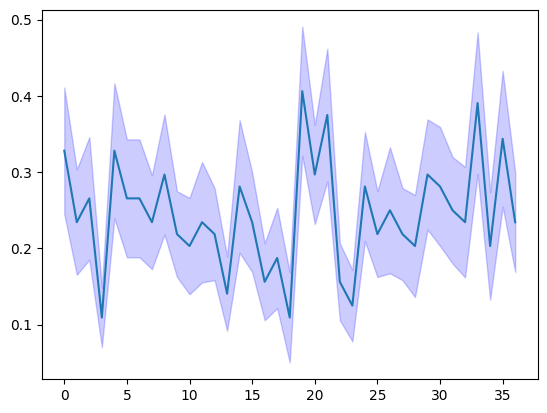

In [48]:
# minlen = min(len(e.past_returns) for e in env.envs)
# past_returns = np.array([e.past_returns[-minlen:] for e in env.envs])
# mean = past_returns.mean(axis=0)
# stderr = past_returns.std(axis=0)/np.sqrt(past_returns.shape[0])
# x = np.arange(len(mean))
# plt.plot(x, mean)
# plt.fill_between(x, mean-stderr, mean+stderr, color=[0, 0, 1, .2])

In [73]:
def temp(rewards, **kwargs):
    # print(rewards.mean().item())
    pass
testing_ppo.run(agent, env, args, callback_fn=temp)

Using cuda
Starting updates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [06:13<00:00,  6.12s/it]


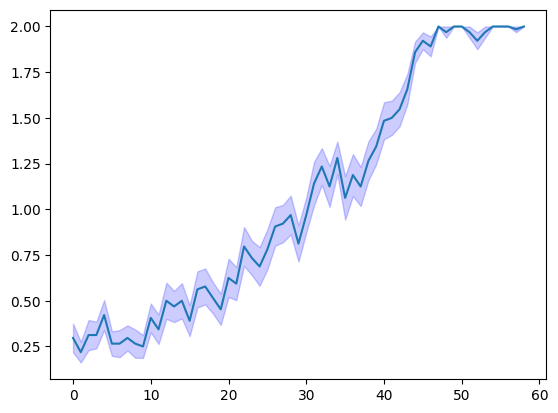

In [74]:
minlen = min(len(e.past_returns) for e in env.envs)
past_returns = np.array([e.past_returns[-minlen:] for e in env.envs])
mean = past_returns.mean(axis=0)
stderr = past_returns.std(axis=0)/np.sqrt(past_returns.shape[0])
x = np.arange(len(mean))
plt.plot(x, mean)
plt.fill_between(x, mean-stderr, mean+stderr, color=[0, 0, 1, .2])

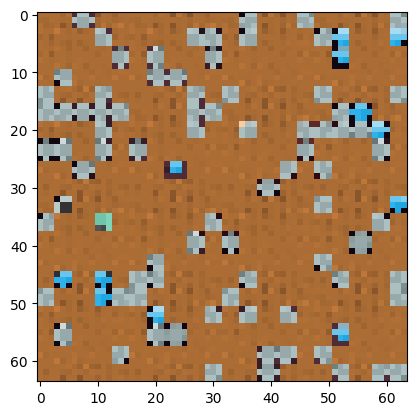

In [75]:
plt.imshow(obs[0])

  0%|                                                                                                                                                                                                                | 0/1100 [00:00<?, ?it/s]

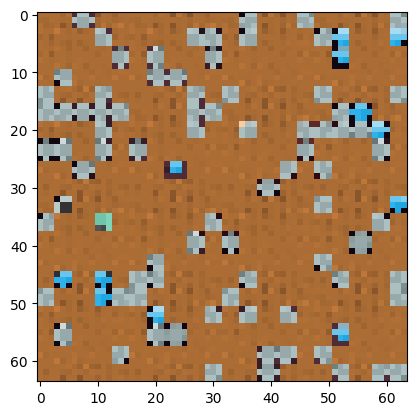

  1%|██▋                                                                                                                                                                                                    | 15/1100 [00:00<00:16, 63.90it/s]

15


In [107]:
e = make_env(1, level_id=0)
obs, info = e.reset()
for i in tqdm(range(1100)):
    pobs = obs
    action, _, _, _ = agent.get_action_and_value(torch.from_numpy(obs).cuda())
    obs, reward, term, trunc, info = e.step(action.tolist())
    
    if term.item() or trunc.item():
        break
    if i%100==0:
        plt.imshow(obs[0])
        plt.show()
print(i)

In [74]:
env = gym_old.make('procgen-miner-v0', num_levels=1, start_level=0)
env = MyProcgenEnv(env)

env.reset()
for i in range(1100):
    obs, _, term, trunc, _ = env.step(4)
    if term or trunc:
        break
print(i)


999


0
('LEFT', 'DOWN')


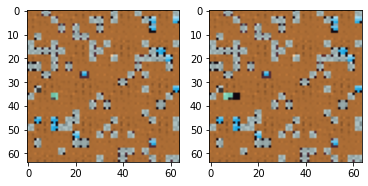

1
('LEFT',)


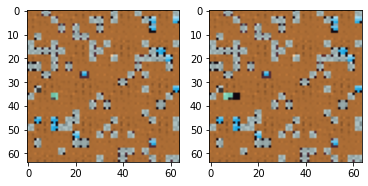

2
('LEFT', 'UP')


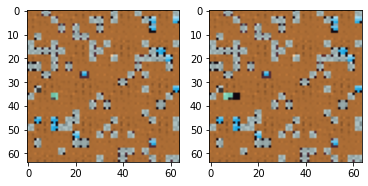

3
('DOWN',)


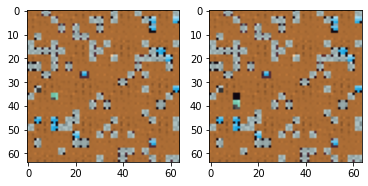

4
()


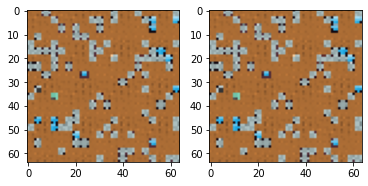

5
('UP',)


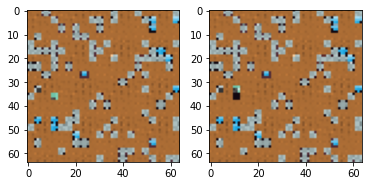

6
('RIGHT', 'DOWN')


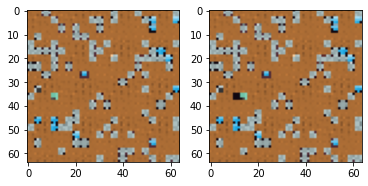

7
('RIGHT',)


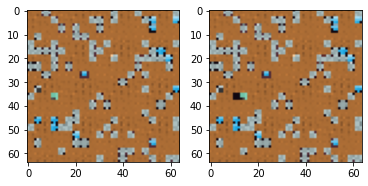

8
('RIGHT', 'UP')


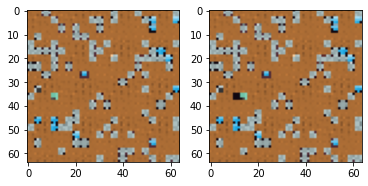

9
('D',)


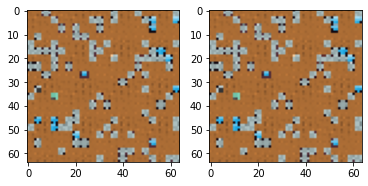

10
('A',)


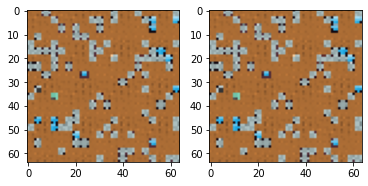

11
('W',)


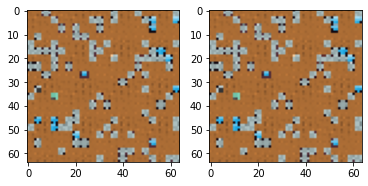

12
('S',)


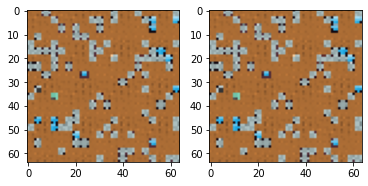

13
('Q',)


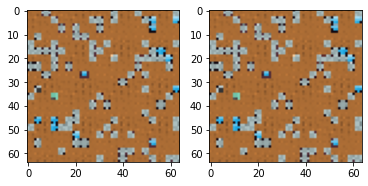

14
('E',)


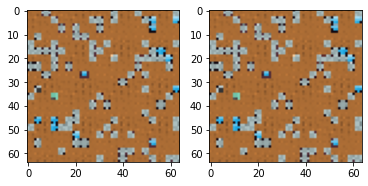

In [55]:
for action in range(env.action_space.n):
    env = gym_old.make('procgen-miner-v0', num_levels=1, start_level=0)
    env = MyProcgenEnv(env)
    print(action)
    print(env.unwrapped.env.env.combos[action])
    obs, info = env.reset()
    plt.subplot(121)
    plt.imshow(obs)
    obs, _, _, _, _ = env.step(action)
    plt.subplot(122)
    plt.imshow(obs)
    plt.show()

In [94]:
a = np.random.randn(100000)*2+9

In [95]:
a.mean(), a.std()

(9.00882760654431, 1.9941847702622102)

In [104]:
rms.mean, np.sqrt(rms.var)

(9.00882759753548, 1.9941847898647571)

In [96]:
rms = gym.wrappers.normalize.RunningMeanStd()

In [97]:
for ai in a.reshape(100, -1):
    rms.update(ai)

In [133]:
env = make_env(1)

/data/vision/phillipi/akumar01/miniconda3/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [134]:
rnd = models.RNDModel()
agent = models.Agent(env)

In [135]:
obs, info = env.reset()
obs.shape

(1, 64, 64, 3)

In [143]:
obs.min()

7.0

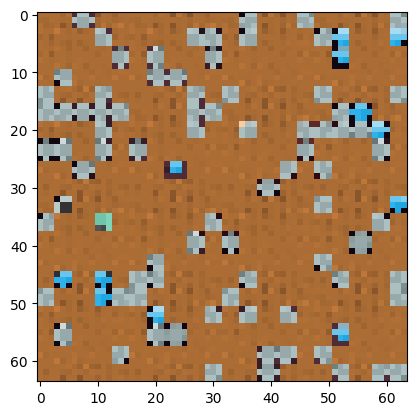

In [144]:
plt.imshow(obs[0]/255.)

In [126]:
np.sum([p.numel() for p in agent.parameters()])

623429

In [123]:
agent.get_action_and_value()

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

In [8]:
env = make_env(3)
obs, info = env.reset()
obs.shape, obs.dtype

((3, 4, 64, 64, 3), dtype('uint8'))

In [21]:
env = make_env(64)

r = []
r_means, r_stds = [], []
def callback(update, rewards, **kwargs):
    if update%1==0:
        r_means.append(np.mean([e.past_returns[-1] for e in env.envs]))
        r_stds.append(np.std([e.past_returns[-1] for e in env.envs]))
        r.append(rewards.mean().item())
        clear_output(wait=True)
        o = kwargs['b_obs'][:, -1].cpu().numpy()
        o = o.std(axis=0).mean(axis=-1)
        plt.imshow(o)
        plt.show()
        plt.figure(figsize=(10, 3))
        plt.subplot(121)
        # plt.plot(r)
        plt.plot(r_means, color='b')
        mean, std = np.array(r_means), np.array(r_stds)
        plt.fill_between(range(len(mean)), mean-std, mean+std, color=[0,0,.2])
        plt.subplot(122)
        plot_rewards(env)
        plt.show()
    
agent = Agent(env)
rnd = RNDModel(env, (64, 64, 3))
n_params = np.sum([p.numel() for p in agent.parameters()])
print(f'Agent # parameters: {n_params:012d}')
n_params = np.sum([p.numel() for p in rnd.parameters()])
print(f'RND   # parameters: {n_params:012d}')

parser = testing_ppo_rnd.parse_args()
args = parser.parse_args('--total-timesteps 5000000 --ext-coef 1.0 --int-coef 0.0 --num-minibatches 50'.split())
args.total_timesteps
testing_ppo_rnd.run(agent, rnd, env, args, callback_fn=callback)

Agent # parameters: 000000472615
RND   # parameters: 000001726784
Using device cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.00 GiB (GPU 0; 11.90 GiB total capacity; 9.15 GiB already allocated; 1.95 GiB free; 9.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

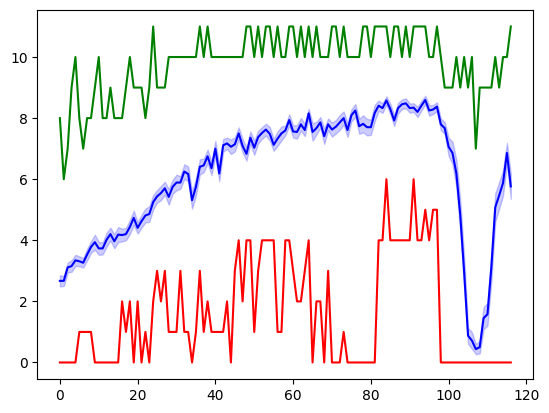

In [168]:
plot_rewards(env)

In [169]:
np.argmax([np.max(e.past_returns) for e in env.envs])

3

In [170]:
np.argmax(env.envs[3].past_returns)

60

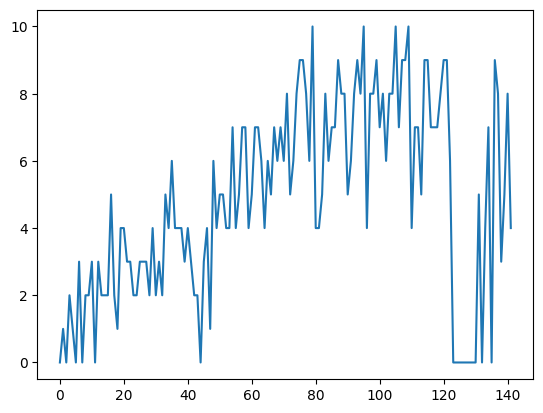

In [176]:
plt.plot(env.envs[0].past_returns)

In [177]:
env.envs[0].past_returns[125]

0.0

In [180]:
env.envs[0].past_returns[-1], env.envs[0].past_lengths[-1]

(4.0, 134)

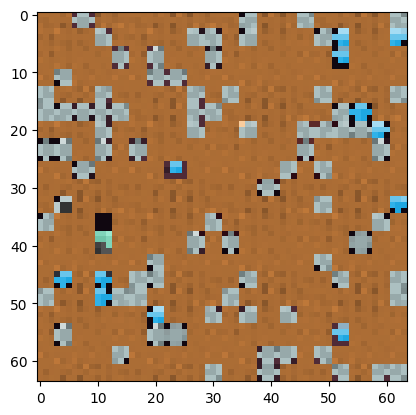

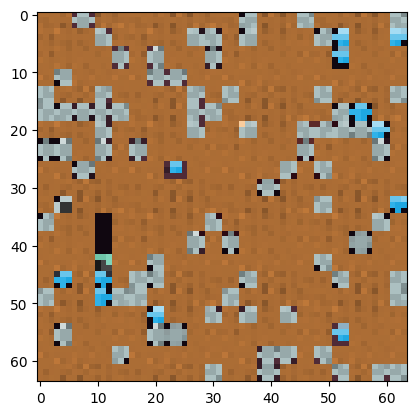

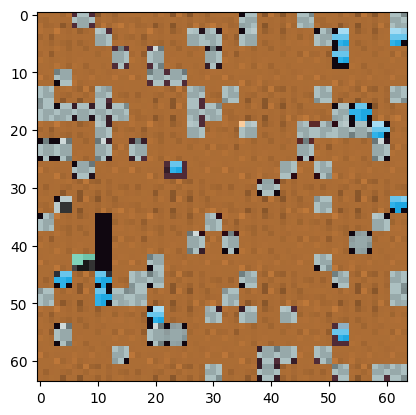

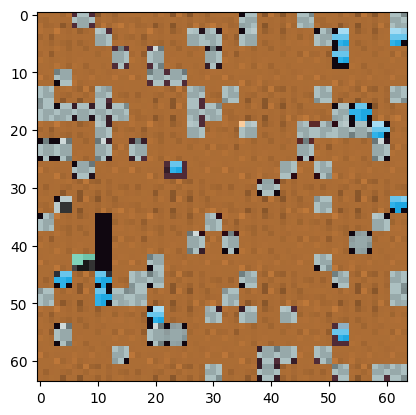

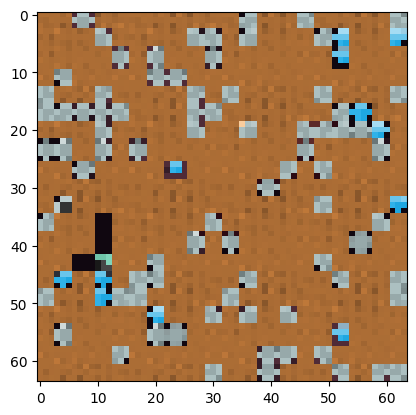

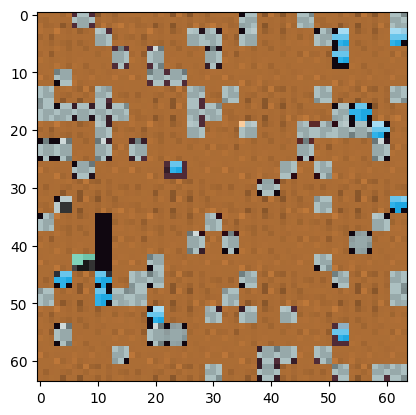

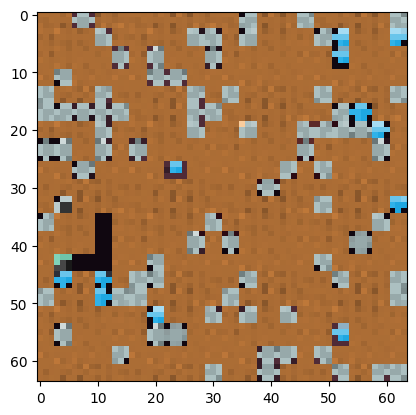

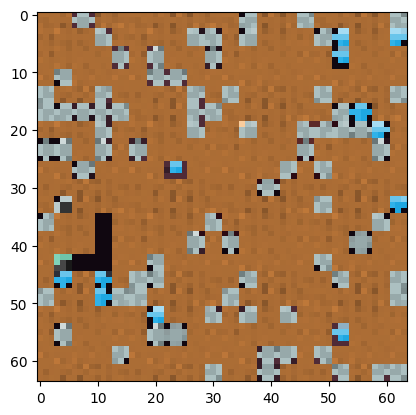

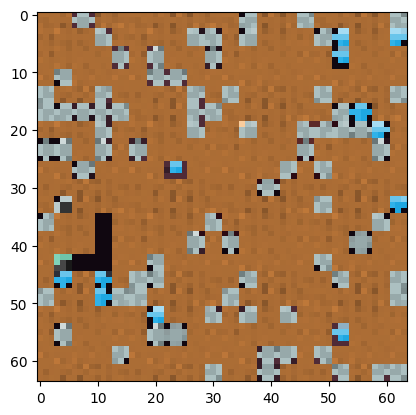

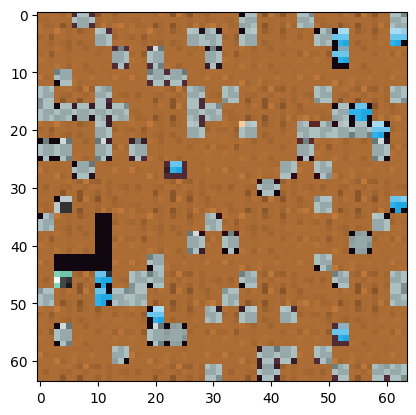

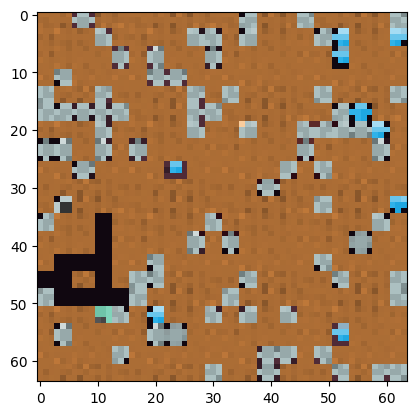

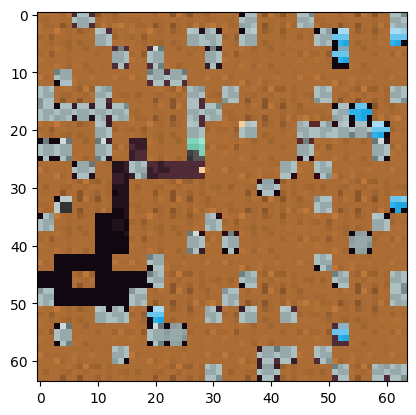

In [181]:
e = make_single_env()
obs, _ = e.reset()
for i, action in enumerate(env.envs[0].past_actions[-1]):
    obs, _, _, _, _ = e.step(action)
    if i<10 or i%50==0:
        plt.imshow(obs[-1])
        plt.show()

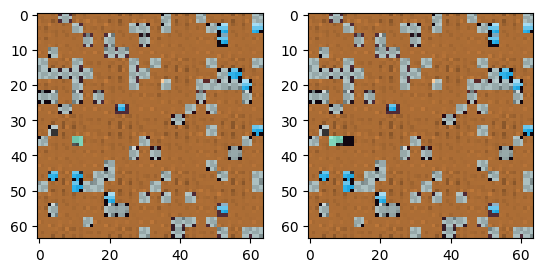

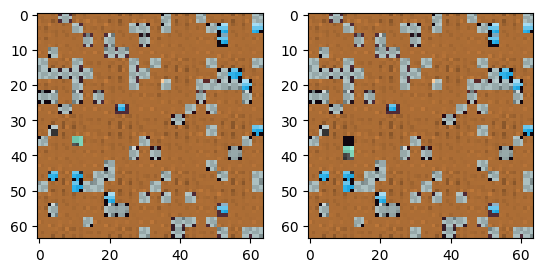

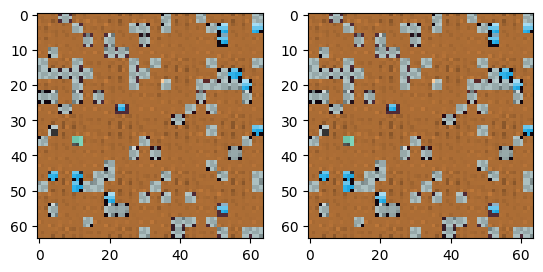

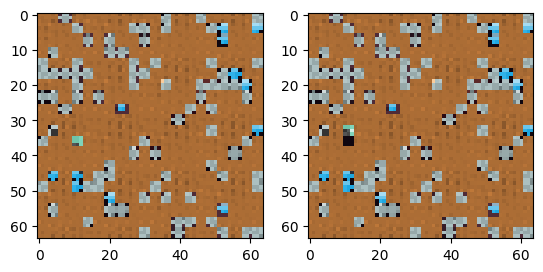

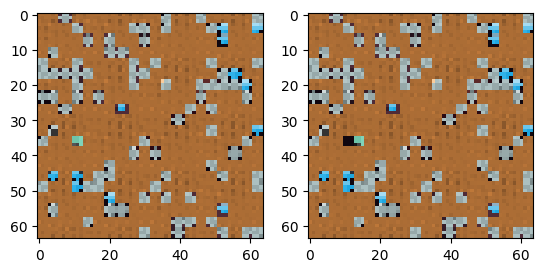

In [53]:

env = make_env(1)
obs, info = env.reset()
for action in range(env.single_action_space.n):
    env = make_env(1)
    obs, info = env.reset()
    plt.subplot(121)
    plt.imshow(obs[0, -1])
    obs, _, _, _, _ = env.step([action])
    plt.subplot(122)
    plt.imshow(obs[0, -1])
    plt.show()
    